In [1]:
import pandas as pd

# Load the Excel file
file_path = "AOD_Met_parameters_6-3-25.xlsx"
xls = pd.ExcelFile(file_path)

df = pd.read_excel(xls, sheet_name="Sheet1")

# Drop unnecessary columns
df = df.drop(columns=["PM10 (Âµg/mÂ³)", "Unnamed: 12", "Unnamed: 13", "Unnamed: 14"], errors="ignore")

# Rename columns for clarity
df = df.rename(columns={
    "PM2.5 (Âµg/mÂ³)": "PM2.5",
    "AT (Â°C)": "Air_Temp",
    "RH (%)": "Relative_Humidity",
    "WS (m/s)": "Wind_Speed",
    "WD (deg)": "Wind_Direction",
    "SR (W/mt2)": "Solar_Radiation",
    "BP (mmHg)": "Pressure",
    "BLH": "Boundary_Layer_Height"
})

# Convert 'Dates' to datetime format
df["Dates"] = pd.to_datetime(df["Dates"])

# Extract datetime features
df["Year"] = df["Dates"].dt.year
df["Month"] = df["Dates"].dt.month
df["Day"] = df["Dates"].dt.day
df["Weekday"] = df["Dates"].dt.weekday  # 0=Monday, 6=Sunday
df["Season"] = df["Month"].apply(lambda x: "Winter" if x in [12, 1, 2] else 
                                           "Spring" if x in [3, 4, 5] else 
                                           "Summer" if x in [6, 7, 8] else "Autumn")

# Compute rolling averages for AOD and met parameters (7-day window)
rolling_features = ["AOD", "Air_Temp", "Relative_Humidity", "Wind_Speed", "Pressure"]
for feature in rolling_features:
    df[f"{feature}_7day_avg"] = df[feature].rolling(window=7, min_periods=1).mean()

# Compute AOD transformations
df["AOD_diff"] = df["AOD"].diff()  # AOD change from previous day

# Create interaction terms
df["AOD_RH"] = df["AOD"] * df["Relative_Humidity"]
df["AOD_BLH"] = df["AOD"] * df["Boundary_Layer_Height"]
df["WS_WD"] = df["Wind_Speed"] * df["Wind_Direction"]

# Encode categorical variables
df["Season"] = df["Season"].astype("category").cat.codes  # Convert seasons to numerical values
df["Location"] = df["Location"].astype("category").cat.codes  # Encode locations

# Drop rows with missing values
df = df.dropna()

# Save the processed file
df.to_csv("Processed_AOD_PM25.csv", index=False)

print("Feature engineering completed. Processed file saved as 'Processed_AOD_PM25.csv'.")


Feature engineering completed. Processed file saved as 'Processed_AOD_PM25.csv'.


In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Load processed data
df = pd.read_csv("Processed_AOD_PM25.csv")

# Mapping location codes to actual names
location_names = {
    0: "Bollaram Industrial Area, Hyderabad - TSPCB",
    1: "Central University, Hyderabad - TSPCB",
    2: "ICRISAT Patancheru, Hyderabad - TSPCB",
    3: "IDA Pashamylaram, Hyderabad - TSPCB",
    4: "Sanathnagar, Hyderabad - TSPCB",
    5: "Zoo Park, Hyderabad - TSPCB"
}

# Prepare results dictionary
results = {}

# Get unique locations
locations = df["Location"].unique()

# Train model for each location
for loc in locations:
    location_name = location_names.get(loc, f"Unknown Location {loc}")
    #print(f"Training model for Location: {location_name}")
    
    # Filter data for the current location
    df_loc = df[df["Location"] == loc]
    
    # Define features and target variable
    X = df_loc.drop(columns=["PM2.5", "Dates", "Location"])
    y = df_loc["PM2.5"]
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train model
    model = RandomForestRegressor(n_estimators=300, random_state=42)
    model.fit(X_train, y_train)
    
    # Predict on train and test sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate model performance for Train and Test sets
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    
    # Store results
    results[location_name] = {
        "R2 (Train)": r2_train, "R2 (Test)": r2_test,
        "RMSE (Train)": rmse_train, "RMSE (Test)": rmse_test,
        "MAE (Train)": mae_train, "MAE (Test)": mae_test
    }
    
    print(f"Location {location_name}:")
    print(f"  R2 (Train) = {r2_train:.4f}, R2 (Test) = {r2_test:.4f}")
    print(f"  RMSE (Train) = {rmse_train:.4f}, RMSE (Test) = {rmse_test:.4f}")
    print(f"  MAE (Train) = {mae_train:.4f}, MAE (Test) = {mae_test:.4f}\n")

# Convert results to DataFrame and save
results_df = pd.DataFrame.from_dict(results, orient="index")
results_df.to_csv("Model_Performance_by_Location.csv")

print("Training completed. Model performance saved in 'Model_Performance_by_Location.csv'.")


Location Bollaram Industrial Area, Hyderabad - TSPCB:
  R2 (Train) = 0.9164, R2 (Test) = 0.5212
  RMSE (Train) = 4.8296, RMSE (Test) = 13.3595
  MAE (Train) = 3.8962, MAE (Test) = 11.1460

Location Central University, Hyderabad - TSPCB:
  R2 (Train) = 0.9319, R2 (Test) = 0.6459
  RMSE (Train) = 4.8917, RMSE (Test) = 11.3093
  MAE (Train) = 3.8564, MAE (Test) = 9.3642

Location ICRISAT Patancheru, Hyderabad - TSPCB:
  R2 (Train) = 0.9254, R2 (Test) = 0.4144
  RMSE (Train) = 5.2450, RMSE (Test) = 15.5591
  MAE (Train) = 4.2127, MAE (Test) = 11.7556

Location IDA Pashamylaram, Hyderabad - TSPCB:
  R2 (Train) = 0.9261, R2 (Test) = 0.5420
  RMSE (Train) = 5.0950, RMSE (Test) = 13.7841
  MAE (Train) = 4.1298, MAE (Test) = 11.4380

Location Sanathnagar, Hyderabad - TSPCB:
  R2 (Train) = 0.8448, R2 (Test) = -0.6372
  RMSE (Train) = 28.5225, RMSE (Test) = 32.7096
  MAE (Train) = 10.7648, MAE (Test) = 22.6311

Location Zoo Park, Hyderabad - TSPCB:
  R2 (Train) = 0.9435, R2 (Test) = 0.5652
  RMSE

C:\Users\Administrator\AppData\Local\Temp\ipykernel_19136\1863178005.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df["R2 Score"], palette="coolwarm")


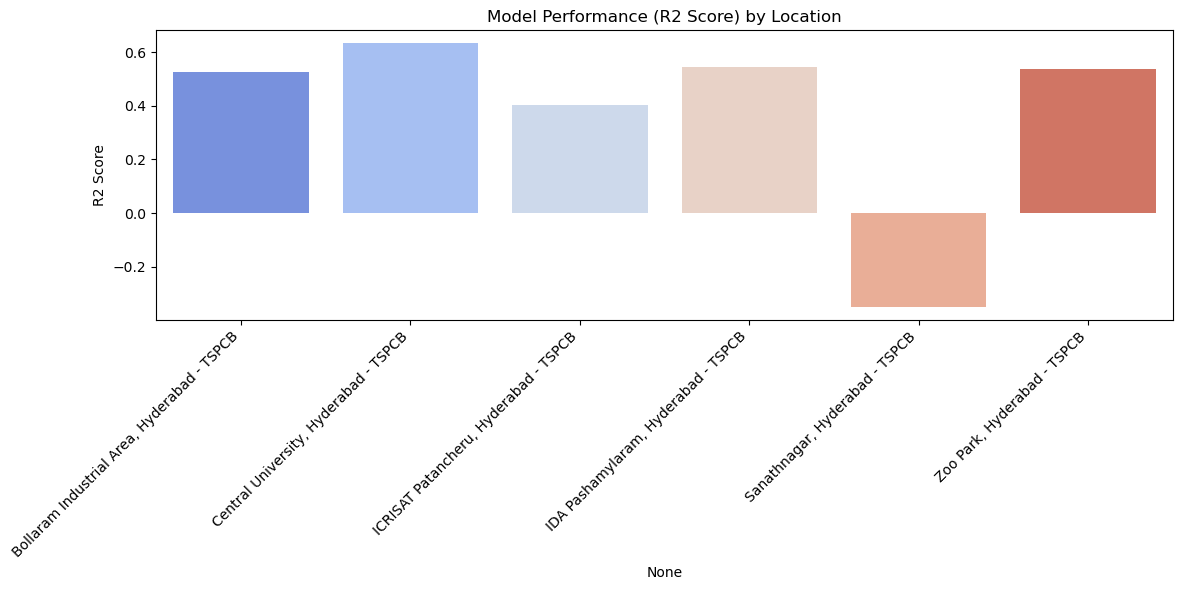

C:\Users\Administrator\AppData\Local\Temp\ipykernel_19136\1863178005.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df["RMSE"], palette="viridis")


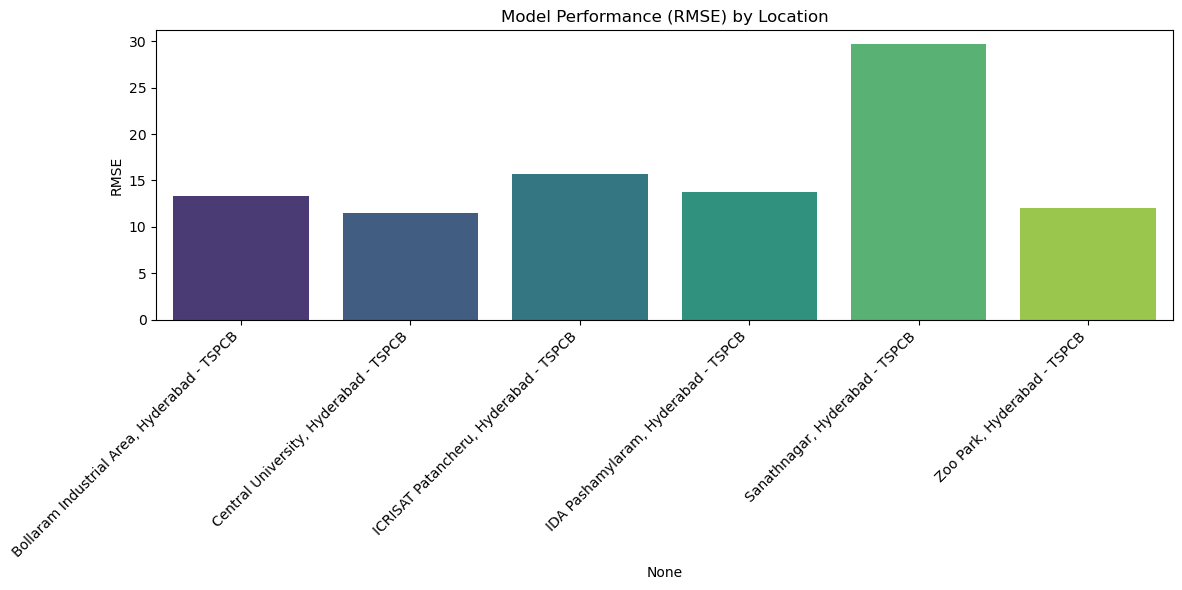

C:\Users\Administrator\AppData\Local\Temp\ipykernel_19136\1863178005.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df["MAE"], palette="magma")


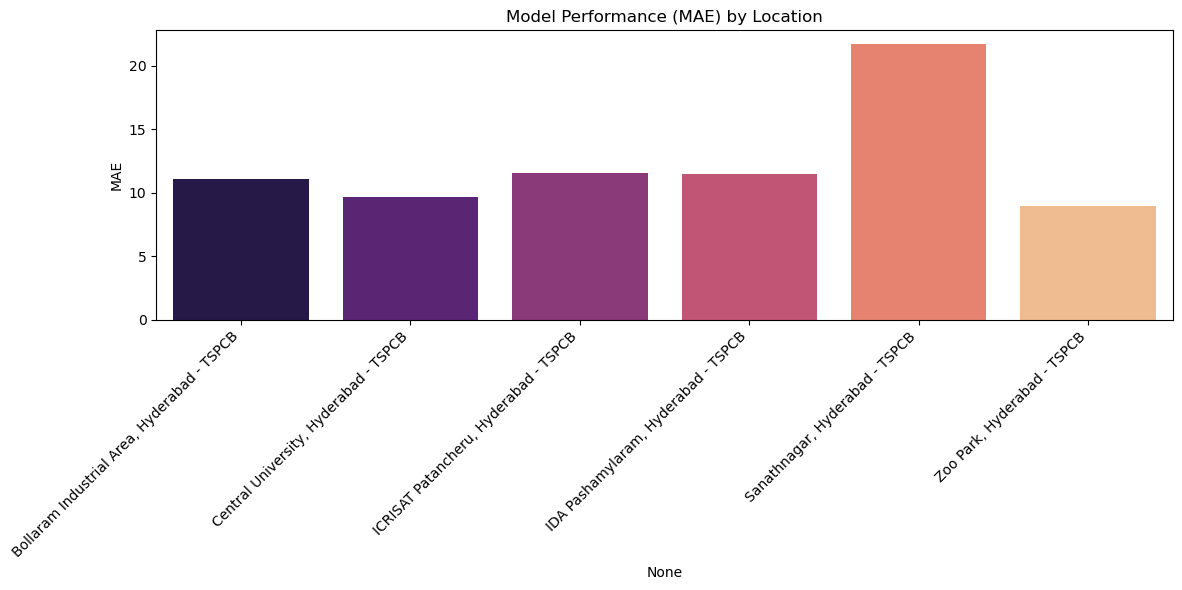

Training completed. Model performance saved in 'Model_Performance_by_Location.csv'.


In [9]:

# Plot Model Performance
plt.figure(figsize=(12, 6))
sns.barplot(x=results_df.index, y=results_df["R2 Score"], palette="coolwarm")
plt.xticks(rotation=45, ha='right')
plt.ylabel("R2 Score")
plt.title("Model Performance (R2 Score) by Location")
plt.tight_layout()
plt.savefig("R2_Score_by_Location.png")
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x=results_df.index, y=results_df["RMSE"], palette="viridis")
plt.xticks(rotation=45, ha='right')
plt.ylabel("RMSE")
plt.title("Model Performance (RMSE) by Location")
plt.tight_layout()
plt.savefig("RMSE_by_Location.png")
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x=results_df.index, y=results_df["MAE"], palette="magma")
plt.xticks(rotation=45, ha='right')
plt.ylabel("MAE")
plt.title("Model Performance (MAE) by Location")
plt.tight_layout()
plt.savefig("MAE_by_Location.png")
plt.show()

print("Training completed. Model performance saved in 'Model_Performance_by_Location.csv'.")


Generating Actual vs Predicted plot for Location: Bollaram Industrial Area, Hyderabad - TSPCB


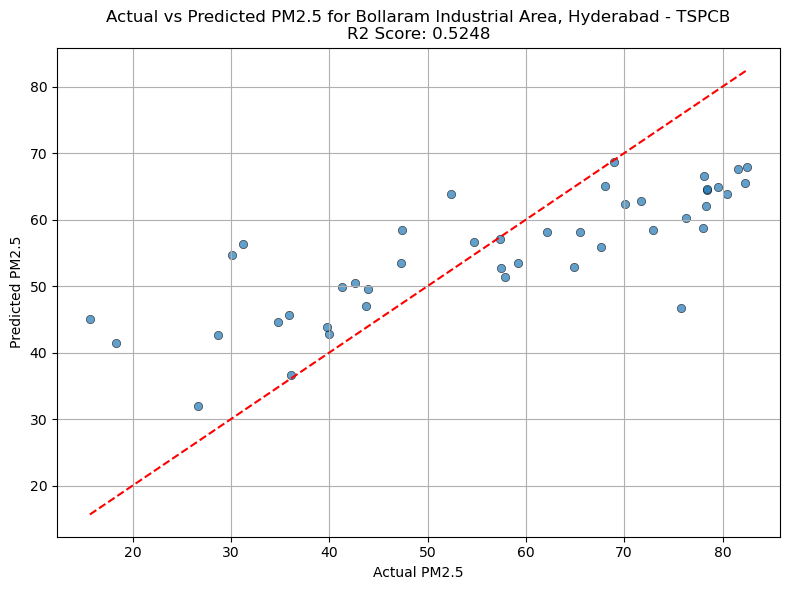

Generating Actual vs Predicted plot for Location: Central University, Hyderabad - TSPCB


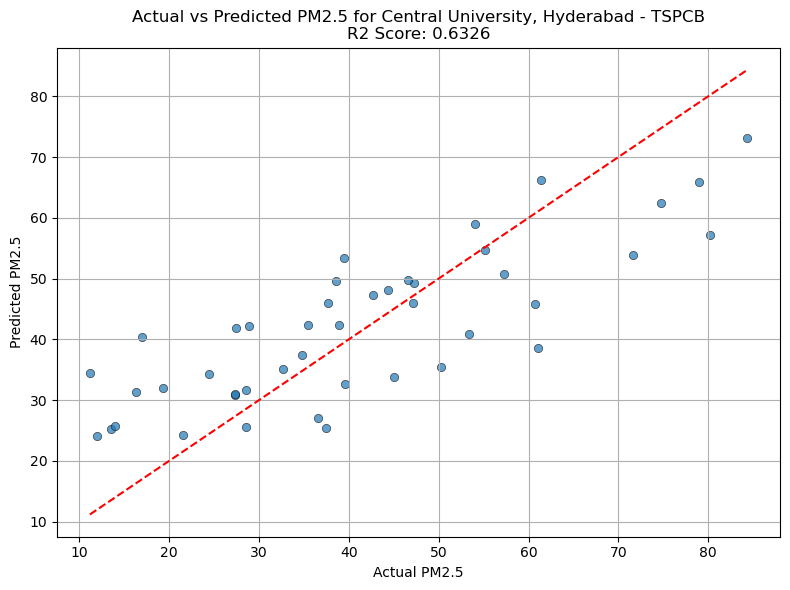

Generating Actual vs Predicted plot for Location: ICRISAT Patancheru, Hyderabad - TSPCB


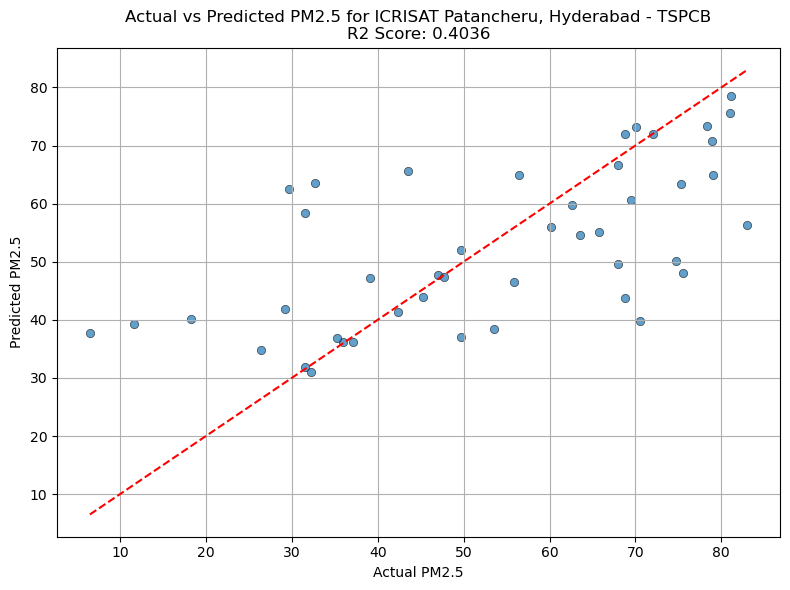

Generating Actual vs Predicted plot for Location: IDA Pashamylaram, Hyderabad - TSPCB


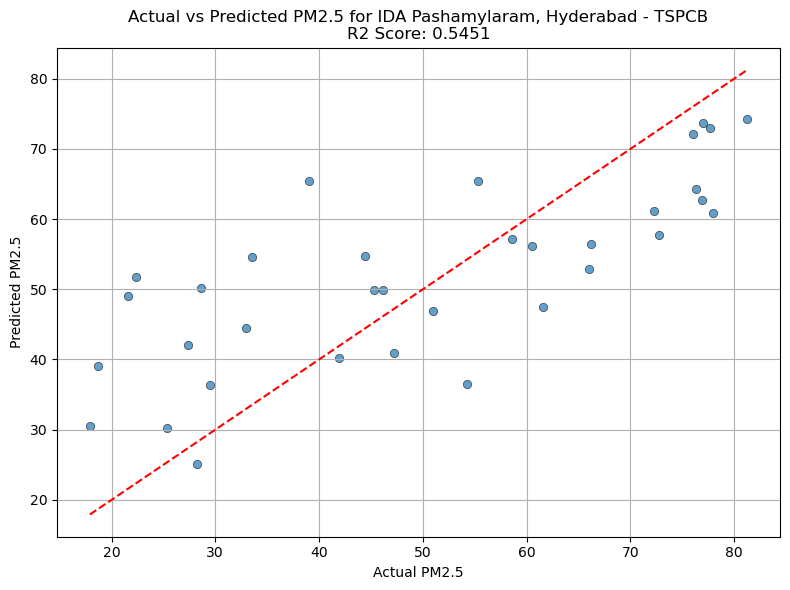

Generating Actual vs Predicted plot for Location: Sanathnagar, Hyderabad - TSPCB


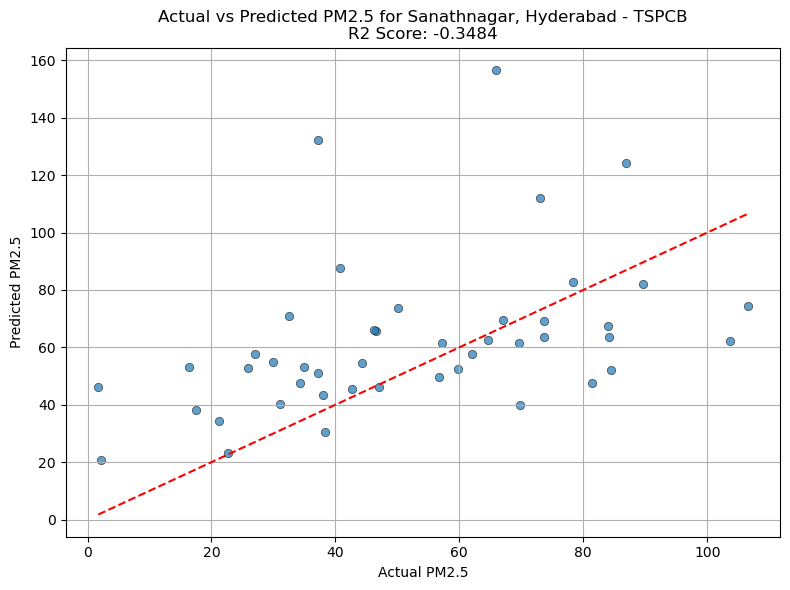

Generating Actual vs Predicted plot for Location: Zoo Park, Hyderabad - TSPCB


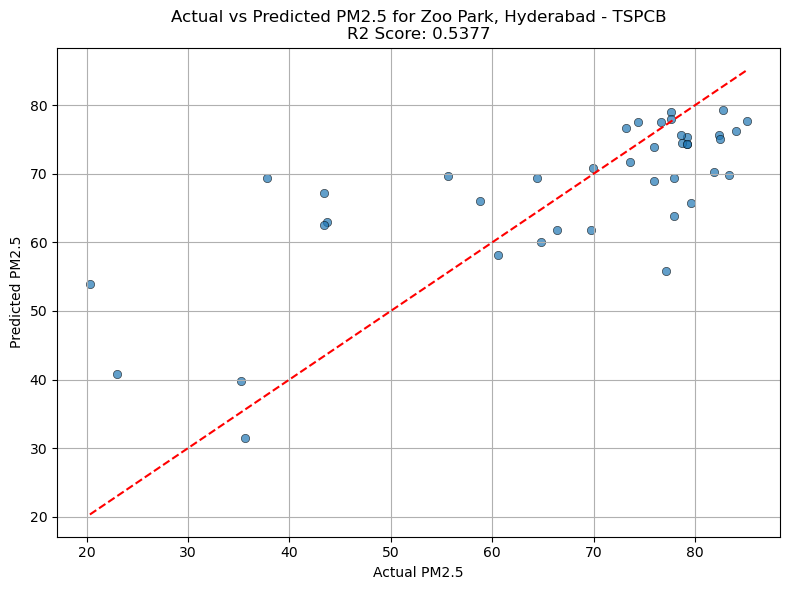

Actual vs Predicted plots generated for all locations.


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Load processed data
df = pd.read_csv("Processed_AOD_PM25.csv")

# Mapping location codes to actual names
location_names = {
    0: "Bollaram Industrial Area, Hyderabad - TSPCB",
    1: "Central University, Hyderabad - TSPCB",
    2: "ICRISAT Patancheru, Hyderabad - TSPCB",
    3: "IDA Pashamylaram, Hyderabad - TSPCB",
    4: "Sanathnagar, Hyderabad - TSPCB",
    5: "Zoo Park, Hyderabad - TSPCB"
}

# Get unique locations
locations = df["Location"].unique()

# Plot Actual vs Predicted for each location
for loc in locations:
    location_name = location_names.get(loc, f"Unknown Location {loc}")
    print(f"Generating Actual vs Predicted plot for Location: {location_name}")
    
    # Filter data for the current location
    df_loc = df[df["Location"] == loc]
    
    # Define features and target variable
    X = df_loc.drop(columns=["PM2.5", "Dates", "Location"])
    y = df_loc["PM2.5"]
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = model.predict(X_test)
    
    # Plot Actual vs Predicted
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.7, edgecolors='k')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
    plt.xlabel("Actual PM2.5")
    plt.ylabel("Predicted PM2.5")
    plt.title(f"Actual vs Predicted PM2.5 for {location_name}\nR2 Score: {r2_score(y_test, y_pred):.4f}")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"Actual_vs_Predicted_{loc}.png")
    plt.show()

print("Actual vs Predicted plots generated for all locations.")
